<a href="https://colab.research.google.com/github/mike-sg/py/blob/main/sales_prediction_mz20210322.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

#Step 1: Data Prep and PreProcessing

##Data Creation

### Inject data from alicloud

In [ ]:
!pip install pyodps[full]


In [ ]:
from odps.tunnel import TableTunnel
from odps import ODPS

ACCESS_ID = 'LTAI4G7pzAvDzbvq3aFLTbkS'
ACCESS_KEY = '1G6hVeJxFqywNpbjNv03GiGvdrgL3v'
PROJECT = 'cks_big_data'
END_POINT = 'http://service.ap-southeast-1.maxcompute.aliyun.com/api'
o = ODPS(ACCESS_ID, ACCESS_KEY, PROJECT, endpoint=END_POINT)
df1 = o.get_table('cks_big_data.ds_dws_training_data').to_df().to_pandas()


In [ ]:
df1

,country,channel,brand,launch,product_line,product_department,product_class,product_code,product_dsc,sku_barcode,...,actual_sold_qty,forecast_qty1,forecast_qty2,forecast_qty3,forecast_qty4,forecast_qty5,forecast_qty6,forecast_qty7,forecast_qty8,forecast_qty9
0,HONG KONG,Retail,CK,Fall 2018,CHARLES & KEITH,Ladies' Sunglass,NA,CK3-31280321,Ladies Sunglass,1002905907230,...,8,0,0,0,0,0,0,0,0,0
1,HONG KONG,Retail,CK,Fall 2019,CHARLES & KEITH,Kids Footwear,Covered,CK9-91700009,Kids Footwear,1003351901476,...,2,0,0,0,0,0,0,0,0,0
2,HONG KONG,Retail,CK,SNBN Fall 2019,CHARLES & KEITH,Ladies Footwear,Covered,CK1-70380624-1,Ladies Footwear,1003423335048,...,29,0,0,0,0,0,0,0,0,0
3,HONG KONG,Retail,CK,Spring 2019,CHARLES & KEITH,Ladies' Footwear,Covered,CK1-70380708-A,Ladies Footwear,1003135101061,...,5,0,0,0,0,0,0,0,0,0
4,HONG KONG,Retail,CK,Spring 2021,CHARLES & KEITH,Ladies Footwear,Covered Open-back,CK1-70900259,Ladies Footwear,1004024701027,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219113,TAIWAN,Retail,CK,Winter 2019,CHARLES & KEITH,Ladies Footwear,Covered,CK1-70900156,Ladies Footwear,1003448435082,...,1,0,0,0,0,0,0,0,0,0
219114,TAIWAN,Retail,CK,Winter 2019,CHARLES & KEITH,Ladies' Bag,NA,CK2-71190008-2,Ladies Bag,1003540393211,...,42,0,0,0,0,0,0,0,0,0
219115,TAIWAN,Retail,CK,Winter 2020,CHARLES & KEITH,Ladies Footwear,Covered,CK1-90900085,Ladies Footwear,1003917101029,...,2,0,0,0,0,0,0,0,0,0
219116,TAIWAN,Retail,CK,Winter 2020,CHARLES & KEITH,Ladies Footwear,Covered,CK1-90920081,Ladies Footwear,1003917301078,...,4,0,0,0,0,0,0,0,0,0


In [ ]:
# Splitting information from launch to year and collection
# df1['year'] = df1['launch'].str.split().str[-1]

In [ ]:
df1['year'] = df1['launch'].str.extract('(\d{4})')


In [ ]:
import string
df1['Collection'] = df1['launch'].str.replace('(\d{4}|\-\d|\d\-)', '').str.strip()

In [ ]:
df1['Collection'].unique()

array(['Fall', 'SNBN Fall', 'Spring', 'Summer', 'Summer JIT', 'Winter',
       'SNBN Spring', 'Winter JIT', 'SeeNowBuyNow', 'Spring  Ramadan',
       'Basic', 'Pedro shoecare', 'Autumn', 'SNBN Winter', 'SNBN Summer',
       'Disney Spring', 'See Now Buy Now', 'Launch', 'Undefined',
       'Fall JIT', '', 'Summer  Ramadan', 'CK Shoecare'], dtype=object)

In [ ]:
x = df1.groupby(['product_department', 'year', 'Collection']).agg({'actual_sold_qty' : sum}).reset_index()

In [ ]:
x[x['product_department']=='Ladies Footwear'][x['Collection']=='Winter'][x['year']>='2017']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,product_department,year,Collection,actual_sold_qty
207,Ladies Footwear,2017,Winter,154571
218,Ladies Footwear,2018,Winter,203830
229,Ladies Footwear,2019,Winter,222798
241,Ladies Footwear,2020,Winter,67490



##Cleaning

In [ ]:
# Removing the product description punctuation marks because there are too many similar descriptions with additional punctuation marks
df1['product_department'] = df1['product_department'].str.replace('[^\w\s]','')

In [ ]:
df1 = df1[(df1['product_line']=='CHARLES & KEITH') & (df1['brand']=='CK')] ## Add brand = ck

In [ ]:
#df1 = df1[(df1['Collection']=='Summer') | (df1['Collection']=='Winter') | (df1['Collection']=='Spring') | (df1['Collection']=='Autumn')]

In [ ]:
df1 = df1[(df1['year']>='2017')&(df1['year']<='2020')]

In [ ]:
df1.isna().sum()

country               0
channel               0
brand                 0
launch                0
product_line          0
product_department    0
product_class         5
product_code          0
product_dsc           0
sku_barcode           0
sap_batch             0
product_color         0
product_size          0
has_repeat            0
has_markdown          0
actual_sold_qty       0
forecast_qty1         0
forecast_qty2         0
forecast_qty3         0
forecast_qty4         0
forecast_qty5         0
forecast_qty6         0
forecast_qty7         0
forecast_qty8         0
forecast_qty9         0
year                  0
Collection            0
dtype: int64

In [ ]:
df1.isnull().sum()

country               0
channel               0
brand                 0
launch                0
product_line          0
product_department    0
product_class         5
product_code          0
product_dsc           0
sku_barcode           0
sap_batch             0
product_color         0
product_size          0
has_repeat            0
has_markdown          0
actual_sold_qty       0
forecast_qty1         0
forecast_qty2         0
forecast_qty3         0
forecast_qty4         0
forecast_qty5         0
forecast_qty6         0
forecast_qty7         0
forecast_qty8         0
forecast_qty9         0
year                  0
Collection            0
dtype: int64

In [ ]:
df1 = df1.dropna()

In [ ]:
df1.shape


(160051, 27)

In [ ]:
df = df1[['country', 'product_department', 'product_class', 'launch', 'product_color', 'product_size', 'year', 'Collection', 'has_repeat', 'has_markdown', 'actual_sold_qty']] # Add launch

## Exploratory Data Analysis

In [ ]:
import seaborn as sns

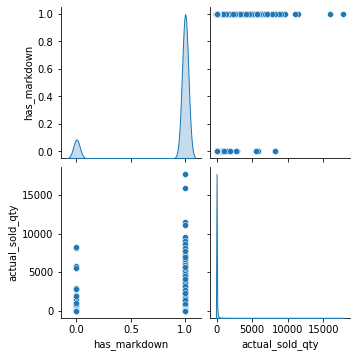

In [ ]:
sns.pairplot(df[['country', 'product_class', 'product_department', 'product_color', 'product_size', 'year', 'Collection', 'has_markdown','actual_sold_qty']], diag_kind='kde')

## Feature Engineering



### Label Encoding

In [ ]:
df.dtypes

country               object
product_department    object
launch                object
product_color         object
product_size          object
year                  object
Collection            object
has_repeat              bool
has_markdown            bool
actual_sold_qty        int64
dtype: object

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
df["country"] = df["country"].astype('category')
df["product_class"] = df["product_class"].astype('category')
df["product_dsc"] = df["product_dsc"].astype('category')
df["product_color"] = df["product_color"].astype('category')
df["product_size"] = df["product_size"].astype('category')
df["year"] = df["year"].astype('category')
df["Collection"] = df["Collection"].astype('category')




In [ ]:
df["country"] = df["country"].cat.codes
df["product_class"] = df["product_class"].cat.codes
df["product_dsc"] = df["product_dsc"].cat.codes
df["product_color"] = df["product_color"].cat.codes
df["product_size"] = df["product_size"].cat.codes
df["year"] = df["year"].cat.codes
df["Collection"] = df["Collection"].cat.codes

In [ ]:
df.head()

,country,product_class,product_dsc,product_color,product_size,year,Collection,has_markdown,actual_sold_qty
3,0,16,17,7,23,4,1,True,5
4,0,17,17,7,19,6,1,False,1
5,0,16,17,51,23,5,2,True,9
7,0,36,12,72,32,3,3,True,155
8,0,16,17,62,23,3,3,False,2


### Feature Weights

Feature: country, Score: 1.42364
Feature: product_class, Score: 1.43129
Feature: product_dsc, Score: -1.45345
Feature: product_color, Score: -0.16475
Feature: product_size, Score: 7.63531
Feature: year, Score: -12.35795
Feature: Collection, Score: -6.43628
Feature: has_markdown, Score: 34.94829


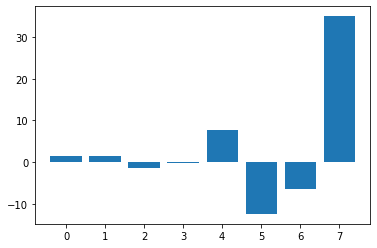

In [ ]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
X, y = df.drop('actual_sold_qty',
  axis='columns'), df['actual_sold_qty']

# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: country, Score: 1.42364
Feature: product_class, Score: 1.43129
Feature: product_dsc, Score: -1.45345
Feature: product_color, Score: -0.16475
Feature: product_size, Score: 7.63531
Feature: year, Score: -12.35795
Feature: Collection, Score: -6.43628
Feature: has_markdown, Score: 34.94826


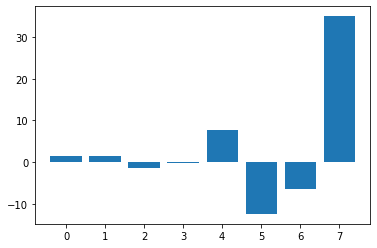

In [ ]:
from sklearn.linear_model import Ridge
from matplotlib import pyplot
# define dataset
X, y = df.drop('actual_sold_qty',
  axis='columns'), df['actual_sold_qty']

# define the model
model = Ridge(alpha=0.01) 

# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### One Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['country', 'product_department', 'product_class', 'launch', 'product_color', 'product_size', 'year', 'Collection'])


In [ ]:
df.shape

(160051, 283)

In [ ]:
df_max_scaled = df.copy() 
  
# apply normalization techniques on Column 1 
column = 'actual_sold_qty'
df_max_scaled[column] = df_max_scaled[column] /df_max_scaled[column].abs().max() 

### Feature Weights

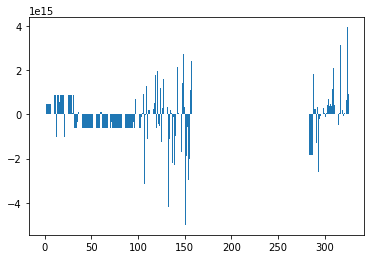

In [ ]:
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot
# define dataset
X, y = df.drop('actual_sold_qty',
  axis='columns'), df['actual_sold_qty']

# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %s, Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: has_repeat, Score: 0.00000
Feature: has_markdown, Score: -5.37360
Feature: country_HONG KONG, Score: -20.82850
Feature: country_JAPAN, Score: -14.42909
Feature: country_MACAU, Score: -34.79593
Feature: country_SINGAPORE, Score: 100.60468
Feature: country_SOUTH KOREA, Score: -14.84188
Feature: country_TAIWAN, Score: -15.70928
Feature: product_department_Bag Straps, Score: -27.30007
Feature: product_department_CSR Merchandise, Score: -638.27221
Feature: product_department_GWP Merchandise, Score: 1045.59526
Feature: product_department_Key Chain, Score: -229.79240
Feature: product_department_Kids Bags, Score: -499.57256
Feature: product_department_Kids Footwear, Score: -296.48340
Feature: product_department_Ladies Accessories, Score: -442.25137
Feature: product_department_Ladies Bag, Score: -452.91412
Feature: product_department_Ladies Bag Strap, Score: -43.57665
Feature: product_department_Ladies Belt, Score: -641.90052
Feature: product_department_Ladies Costume Jewellery, Score:

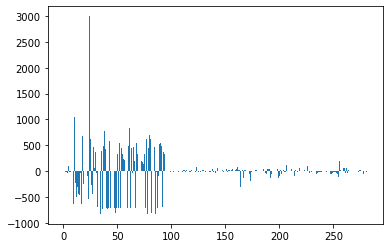

In [ ]:
from sklearn.linear_model import Ridge
from matplotlib import pyplot
# define dataset
X, y = df.drop('actual_sold_qty',
  axis='columns'), df['actual_sold_qty']

# define the model
model = Ridge(alpha=0.01) 

# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Step 2: Model Selection

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((128040, 282), (32011, 282))

## Linear Regression


In [ ]:
rr = Ridge(alpha=0.01) 

In [ ]:
reg = rr.fit(X_train, y_train)

In [ ]:
y_predicted = rr.predict(X_test)

In [ ]:
model.score(X_test, y_test)

0.1707238393403544

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_predicted))

205.47824402226348

In [ ]:
y_predicted

array([104.6571454 ,  83.58262853,  29.5239926 , ...,  90.07198607,
         4.42767627, 171.66403402])

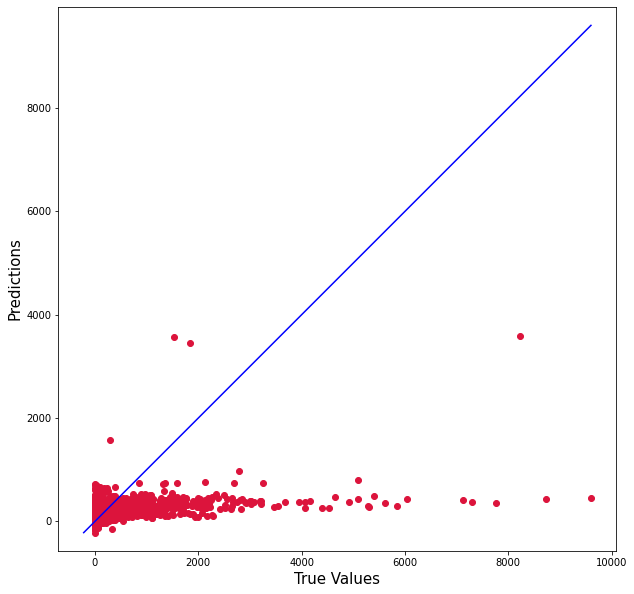

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')


p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=3
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train[:10000],y_train[:10000])

NameError: ignored

In [ ]:
y_predicted_poly = polyreg.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_predicted_poly))

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted_poly, c='crimson')


p1 = max(max(y_predicted_poly), max(y_test))
p2 = min(min(y_predicted_poly), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Neural Net

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras.layers.core import Dropout



In [ ]:
def baseline_model(l1=100, l2=50):
	  # create model
  model = Sequential()
  model = Sequential()
  model.add(Dense(l1, input_dim=feature_size, kernel_initializer='normal', activation='relu'))
  model.add(Dense(l2, input_dim=l1, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, activation='relu'))
  # Compile model
  #optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

  model.compile(loss='mean_absolute_error', optimizer='adamax')
  return model

In [ ]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
feature_size = X_train.shape[1]

NameError: ignored

In [ ]:
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=1)))
# pipeline = Pipeline(estimators)
# kfold = KFold(n_splits=2)
# results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (np.sqrt(np.abs(results.mean())), np.sqrt(results.std())))

estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=50, verbose=1)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
from sklearn.model_selection import GridSearchCV
model = KerasRegressor(build_fn=baseline_model, verbose=1)
batch_size = [100, 200, 400, 1000]
epochs = [10, 50, 100,300]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error',verbose = 1)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
model = KerasRegressor(build_fn=baseline_model, verbose=1, epochs=300, batch_size=400)
l1 = [60, 100, 200]
l2 = [30, 50 ,100]
param_grid = dict(l1=l1, l2=l2)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error', cv=2)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def baseline_model():
	  # create model
  model = Sequential()
  model = Sequential()
  model.add(Dense(200, input_dim=feature_size, kernel_initializer='normal', activation='relu'))
  model.add(Dense(50, input_dim=200, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, activation='relu'))
  # Compile model
  #optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

  model.compile(loss='mean_absolute_error', optimizer='adamax')
  return model
estimator = KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=400, verbose=1)
estimator.fit(X_train, y_train)



In [ ]:
preds = estimator.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, preds))

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(y_test, preds, c='crimson')


p1 = max(max(preds), max(y_test))
p2 = min(min(preds), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Step 3: Train the model

## Validation against existing sales

## Compare accuracy and analysis

## Fine Tuning the models

## Regularization

# Step 4: Evaluate, Select and Deploy the Model



```
# This is formatted as code
```

# Step 5: Visualisation